<a href="https://colab.research.google.com/github/Erayymsk/Pusula_Berk_Eray_Yumusak/blob/main/Case_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import datetime as dt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 400)

In [54]:
# Excel Dosyasını Okuma İşlemi
df2 = pd.read_excel(
    "/content/side_effect_data_1.xlsx",
    index_col="Kullanici_id")
df = df2.copy()


In [60]:
df.reset_index(inplace=True)

In [55]:
# Veri Setini İnceleyelim
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

check_df(df)

##################### Shape #####################
(2357, 18)
##################### Types #####################
Cinsiyet                                    object
Dogum_Tarihi                        datetime64[ns]
Uyruk                                       object
Il                                          object
Ilac_Adi                                    object
Ilac_Baslangic_Tarihi               datetime64[ns]
Ilac_Bitis_Tarihi                   datetime64[ns]
Yan_Etki                                    object
Yan_Etki_Bildirim_Tarihi            datetime64[ns]
Alerjilerim                                 object
Kronik Hastaliklarim                        object
Baba Kronik Hastaliklari                    object
Anne Kronik Hastaliklari                    object
Kiz Kardes Kronik Hastaliklari              object
Erkek Kardes Kronik Hastaliklari            object
Kan Grubu                                   object
Kilo                                       float64
Boy                   

In [56]:
# Veri Tiplerini Yakalayalım
def grab_col_names(dataframe, cat_th=10, car_th=30):
    """
        Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
        Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

        Parameters
        ------
            dataframe: dataframe
                    Değişken isimleri alınmak istenilen dataframe
            cat_th: int, optional
                    numerik fakat kategorik olan değişkenler için sınıf eşik değeri
            car_th: int, optinal
                    kategorik fakat kardinal değişkenler için sınıf eşik değeri

        Returns
        ------
            cat_cols: list
                    Kategorik değişken listesi
            num_cols: list
                    Numerik değişken listesi
            cat_but_car: list
                    Kategorik görünümlü kardinal değişken listesi

        Examples
        ------
            import seaborn as sns
            df = sns.load_dataset("iris")
            print(grab_col_names(df))


        Notes
        ------
            cat_cols + num_cols + cat_but_car = toplam değişken sayısı
            num_but_cat cat_cols'un içerisinde.
            Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken
            sayısı

        """

    # cat_cols, cat_but_car
    cat_cols = [
        col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique(
    ) < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique(
    ) > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [
        col for col in dataframe.columns if dataframe[col].dtypes in [
            "int64", "float64"]]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # date_cols
    date_cols = [
        col for col in dataframe.columns if dataframe[col].dtypes == "datetime64[ns]"]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print(f"date_cols: {len(date_cols)}")
    return cat_cols, num_cols, cat_but_car, date_cols


cat_cols, num_cols, cat_but_car, date_cols = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "Kullanici_id"]
cat_cols = [col for col in cat_cols if col not in "Uyruk"]

Observations: 2357
Variables: 18
cat_cols: 6
num_cols: 2
cat_but_car: 6
num_but_cat: 0
date_cols: 4


<Axes: >

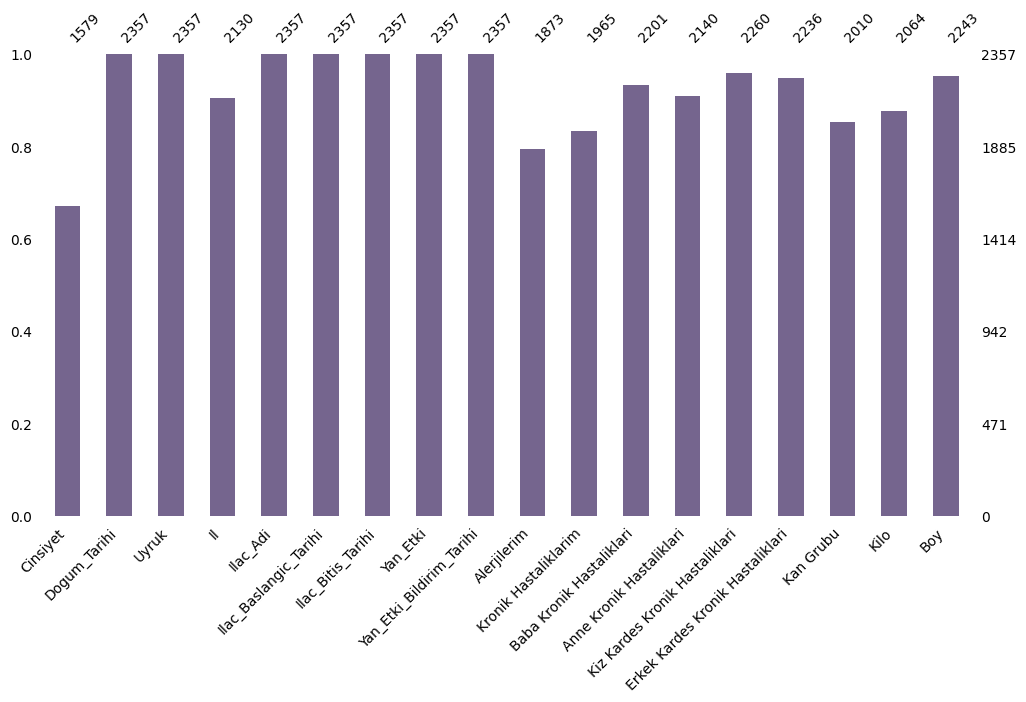

In [57]:
# Eksik Verileri İnceleyelim
msno.bar(df, color="#75658e", figsize=(12, 6), fontsize=10)

In [58]:
# Eksik Veri Frekansları ve Tablosu
def missing_values_table(dataframe, na_name=False):
    na_columns = [
        col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (
        dataframe[na_columns].isnull().sum() /
        dataframe.shape[0] *
        100).sort_values(
        ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)],
                           axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


missing_values_table(df)

                                  n_miss  ratio
Cinsiyet                             778  33.01
Alerjilerim                          484  20.53
Kronik Hastaliklarim                 392  16.63
Kan Grubu                            347  14.72
Kilo                                 293  12.43
Il                                   227   9.63
Anne Kronik Hastaliklari             217   9.21
Baba Kronik Hastaliklari             156   6.62
Erkek Kardes Kronik Hastaliklari     121   5.13
Boy                                  114   4.84
Kiz Kardes Kronik Hastaliklari        97   4.12


          Cinsiyet      Ratio
Cinsiyet                     
Female         872  36.996182
Male           707  29.995757
##########################################


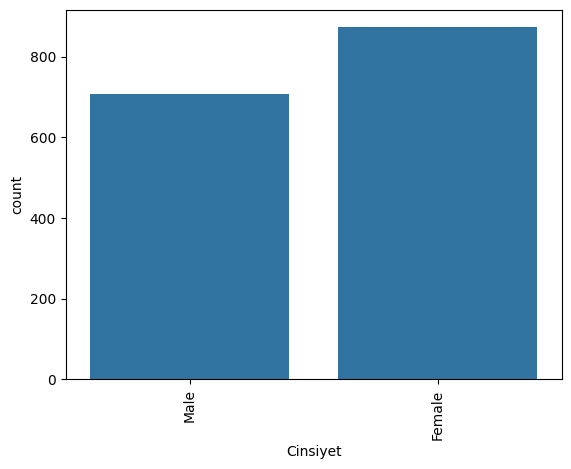

            Il     Ratio
Il                      
Adana      220  9.333899
Mersin     207  8.782350
Trabzon    195  8.273229
Canakkale  179  7.594400
Ankara     179  7.594400
Eskisehir  174  7.382266
Antalya    171  7.254985
Bursa      169  7.170132
Samsun     153  6.491303
Istanbul   144  6.109461
Izmir      121  5.133644
Malatya    109  4.624523
Kayseri    109  4.624523
##########################################


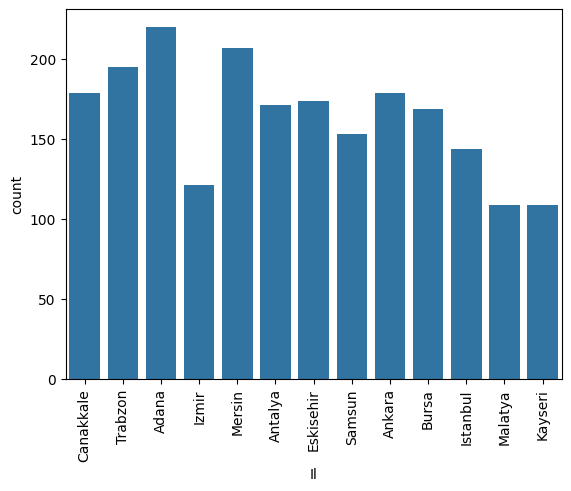

                       Yan_Etki     Ratio
Yan_Etki                                 
Agizda Farkli Bir Tat       229  9.715740
Tansiyon Yukselme           227  9.630887
Yorgunluk                   204  8.655070
Gormede Bulaniklik          170  7.212558
Kabizlik                    156  6.618583
Ishal                       145  6.151888
Az Uyuma                    141  5.982181
Terleme                      97  4.115401
Sinirlilik                   81  3.436572
Gec Bosalma                  81  3.436572
Gucsuzluk                    81  3.436572
Mide Bulantisi               80  3.394145
Tansiyon Dusuklugu           74  3.139584
Carpinti                     72  3.054731
Istah Artisi                 71  3.012304
Bas Agrisi                   71  3.012304
Karin Agrisi                 69  2.927450
Uykululuk Hali               68  2.885023
Bulanti                      64  2.715316
Huzursuzluk                  63  2.672889
Kas Agrisi                   58  2.460755
Deride Morarma               55  2

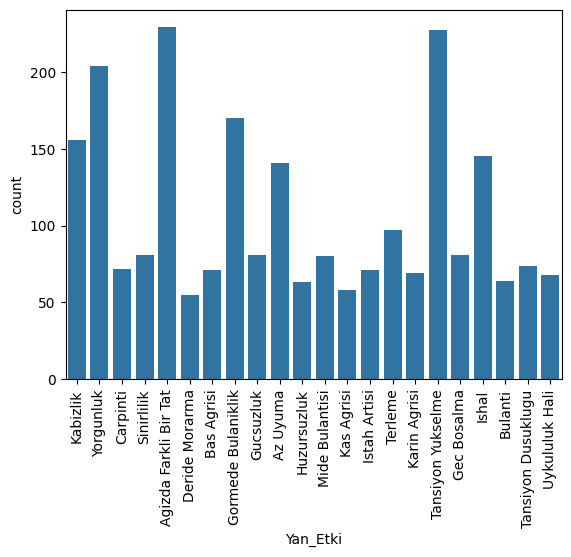

                 Alerjilerim     Ratio
Alerjilerim                           
Domates                  118  5.006364
Karaciger                109  4.624523
Pancar                   100  4.242681
Balik                     98  4.157828
Havyar                    97  4.115401
Ispanakgiller             95  4.030547
Kopek                     91  3.860840
Kefir                     91  3.860840
Yogurt                    89  3.775986
Deniz Urunler             87  3.691133
Muz                       81  3.436572
Kabak Cekirdegi           77  3.266865
Kahve                     76  3.224438
Sari Kantaron             75  3.182011
Toz                       70  2.969877
Laktoz                    60  2.545609
Bugday                    55  2.333475
Cikolata                  53  2.248621
Elma                      53  2.248621
Ispanak                   48  2.036487
Istiridye                 46  1.951633
Bal                       43  1.824353
Kedi                      38  1.612219
Lateks                   

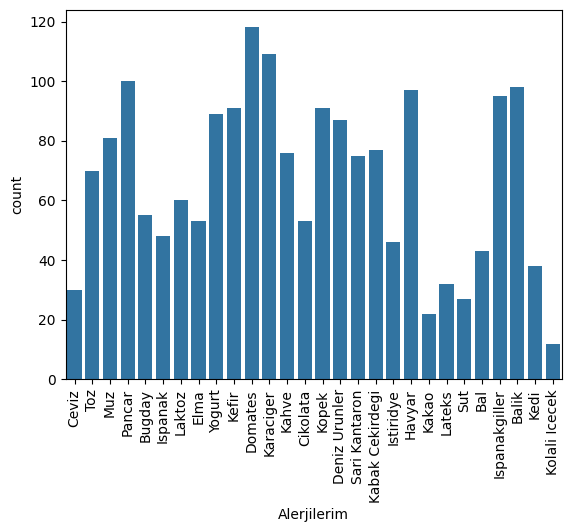

           Kan Grubu      Ratio
Kan Grubu                      
AB RH-           421  17.861689
0 RH+            275  11.667374
B RH+            256  10.861264
AB RH+           250  10.606703
B RH-            233   9.885448
0 RH-            232   9.843021
A RH+            198   8.400509
A RH-            145   6.151888
##########################################


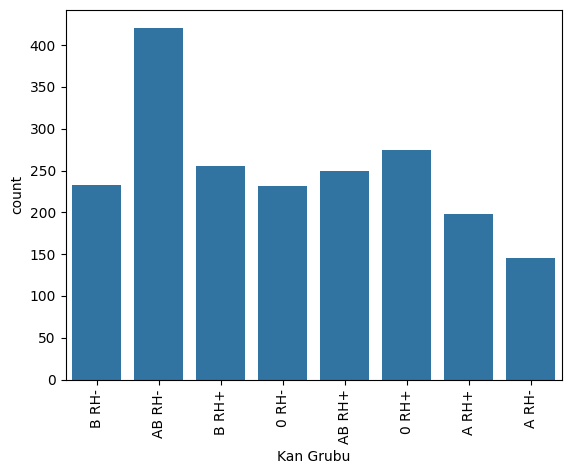

In [62]:
# Kategorik Verilerin Analizi Ve Görselleştirşmesi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(), "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.xticks(rotation=90)
        plt.show(block=True)


for col in cat_cols:
    cat_summary(df, col, True)

count    2064.000000
mean       80.863857
std        18.635269
min        50.000000
5%         51.000000
10%        53.000000
20%        59.000000
30%        68.000000
40%        78.000000
50%        83.000000
60%        90.000000
70%        94.000000
80%        98.000000
90%       107.000000
95%       108.000000
99%       110.000000
max       110.000000
Name: Kilo, dtype: float64


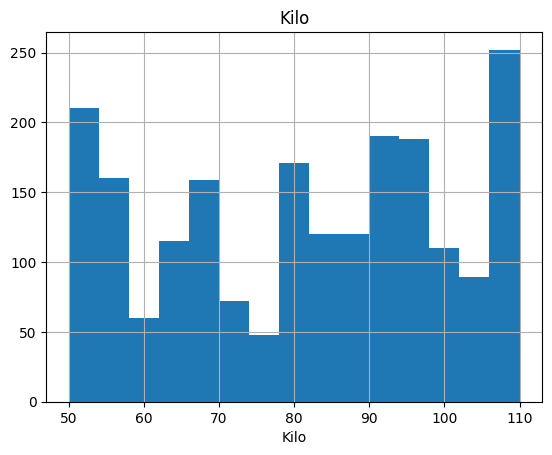

count    2243.000000
mean      174.638431
std        16.516552
min       145.000000
5%        147.000000
10%       150.000000
20%       158.000000
30%       163.000000
40%       169.000000
50%       176.000000
60%       181.000000
70%       185.000000
80%       189.000000
90%       197.000000
95%       201.000000
99%       203.000000
max       203.000000
Name: Boy, dtype: float64


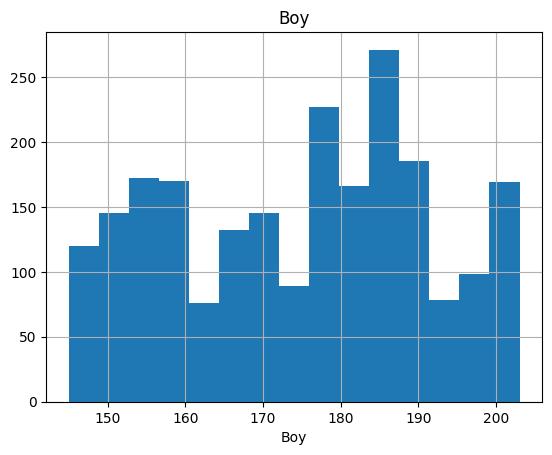

In [63]:
# Numerik Verilerin Analizi ve Görselleştirilmesi
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [
        0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=15)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


for col in num_cols:
    num_summary(df, col, plot=True)

# Yeni Değişkenler ve Çaprazlamalar

In [64]:
# Yaş değişkeninin oluşturulması ve Kategorileştirilmesi
suan = dt.datetime.now()
df["Yas"] = df["Dogum_Tarihi"].apply(
    lambda x: suan.year - x.year - ((suan.month, suan.day) < (x.month, x.day)))
df["Kategorik_Yas"] = pd.cut(df["Yas"],
                             bins=[0, 18, 35, 65, np.max(df["Yas"])],
                             labels=["Çocuk", "Genç", "Orta Yaşlı", "Yaşlı"])

df["Kategorik_Yas"].value_counts()

Kategorik_Yas
Orta Yaşlı    1072
Genç           578
Yaşlı          576
Çocuk          131
Name: count, dtype: int64

In [68]:
# VKI değişkeninin oluşturulması ve Kategorileştirişmesi
df["VKI"] = df["Kilo"] / (df["Boy"] / 100) ** 2
df["Kategorik_VKI"] = pd.cut(
    x=df["VKI"],
    bins=[
        0, 18.5, 24.9, 29.9, 39.9, (df["VKI"].max())],
    labels=[
        "Zayıf",
        "Normal Kilolu",
        "Fazla Kilolu",
        "Obez",
        "Aşırı Obez"])

df["Kategorik_VKI"].value_counts()

Kategorik_VKI
Fazla Kilolu     498
Obez             468
Normal Kilolu    427
Zayıf            347
Aşırı Obez       210
Name: count, dtype: int64

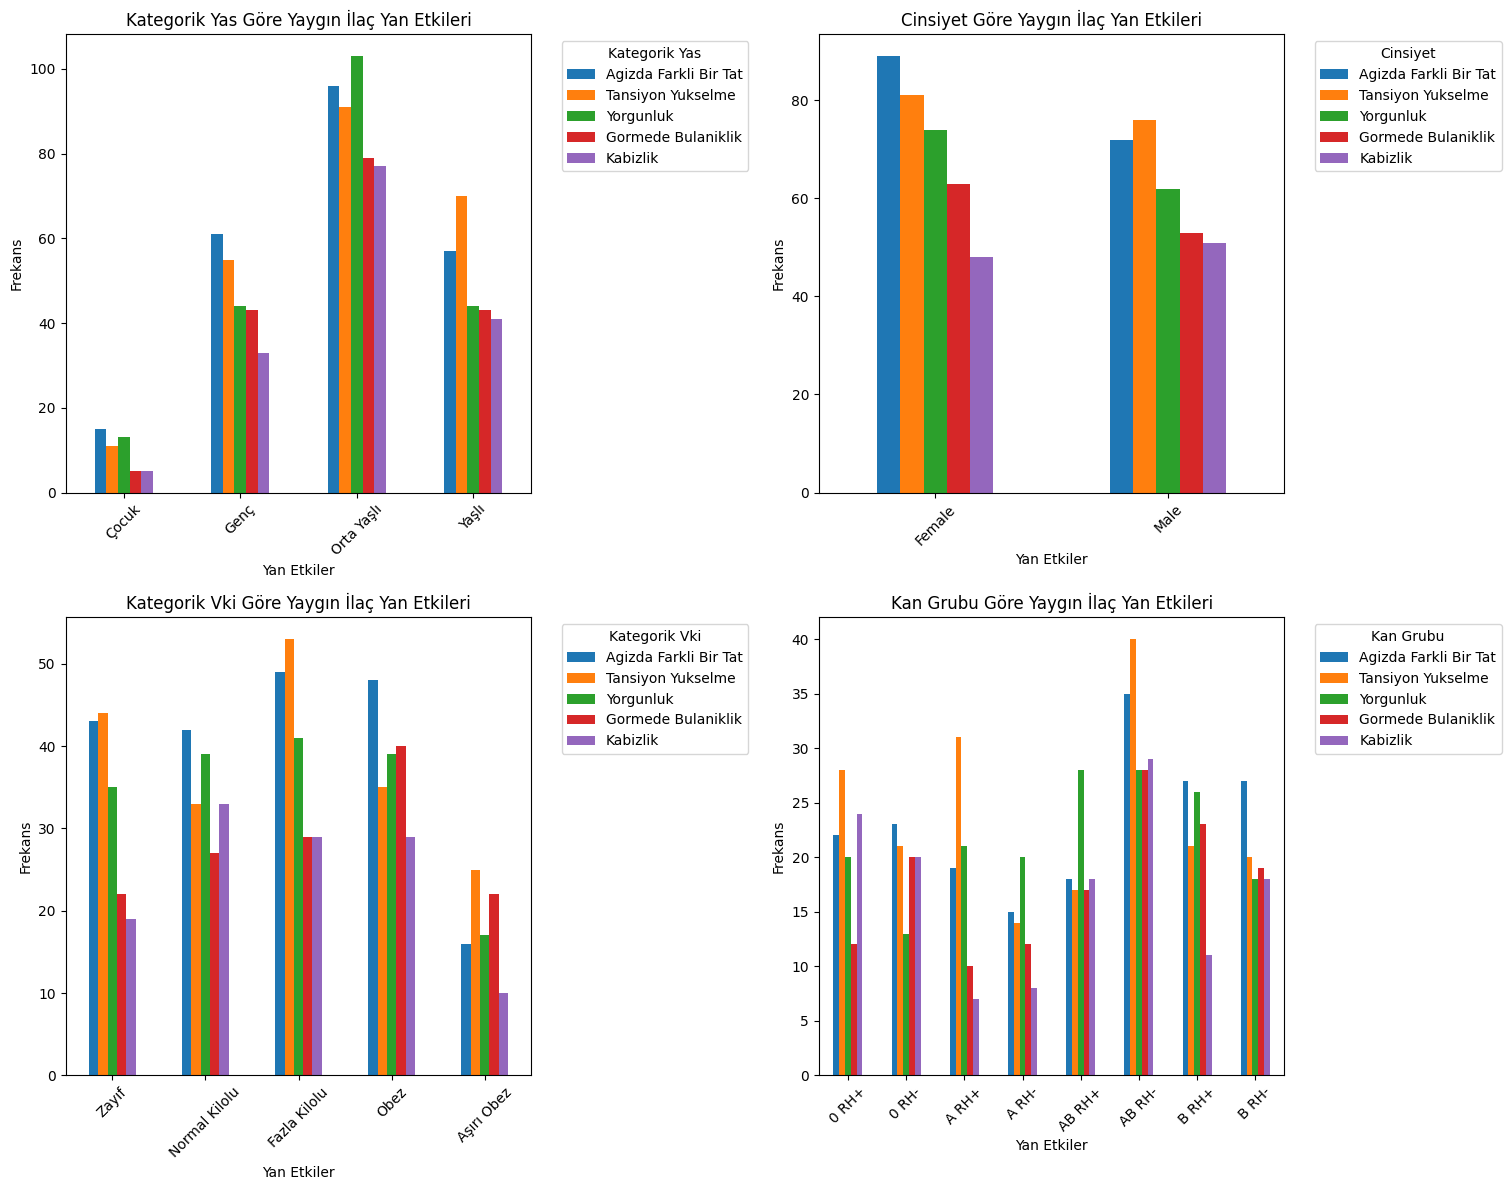

In [70]:
# Seçili Kategorik Verilerde Görülen En Yaygın 5 Yan Etki
group_cols = ["Kategorik_Yas", "Cinsiyet", "Kategorik_VKI", "Kan Grubu"]

# Plotları döngü ile oluştur
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()

for ax, group_col in zip(axes, group_cols):
    group_yan_etki = df.groupby([group_col, "Yan_Etki"]).size().unstack(fill_value=0)
    filtered_yan_etki = group_yan_etki[top5_yan_etki]

    filtered_yan_etki.plot(kind="bar", ax=ax)
    ax.set_xlabel("Yan Etkiler")
    ax.set_ylabel("Frekans")
    ax.set_title(f"{group_col.replace('_', ' ').title()} Göre Yaygın İlaç Yan Etkileri")
    ax.set_xticklabels(filtered_yan_etki.index, rotation=45)
    ax.legend(title=group_col.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

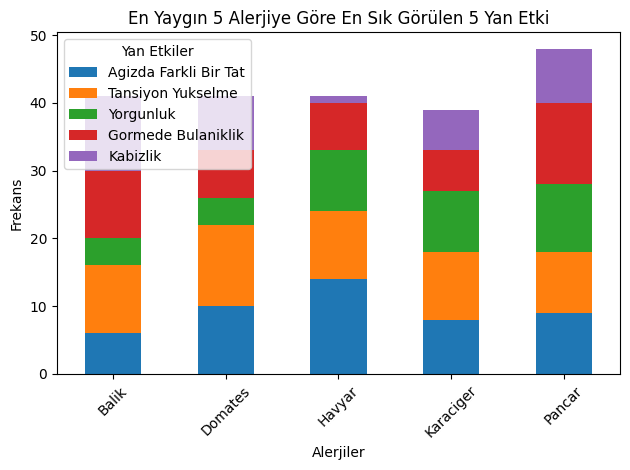

In [71]:
# En Yaygın 5 Alerjide Görülen En Yaygın 5 Yan Etki
en_yaygin_alerjiler = df["Alerjilerim"].value_counts(
    ascending=False).head(5).index
filtered_df = df[df["Alerjilerim"].isin(en_yaygin_alerjiler)]
alerji_yan_etki = filtered_df.groupby(
    ['Alerjilerim', "Yan_Etki"]).size().unstack(fill_value=0)
filtreed_yan_etki = alerji_yan_etki.loc[:, top5_yan_etki]

filtreed_yan_etki.plot(kind="bar", stacked=True)
plt.xlabel("Alerjiler")
plt.ylabel("Frekans")
plt.title("En Yaygın 5 Alerjiye Göre En Sık Görülen 5 Yan Etki")
plt.xticks(rotation=45)
plt.legend(title="Yan Etkiler")
plt.tight_layout()
plt.show()

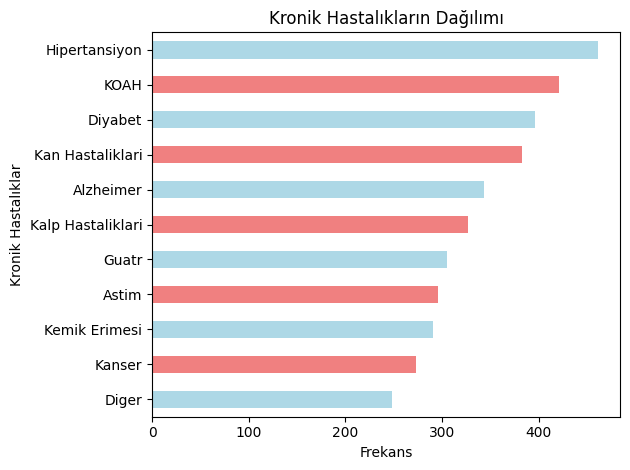

In [72]:
# Kronik Rahatsızlıkları Tekilleştirme ve Frekans Dağılımı Tablosu
df_kronik = df.copy()
df_kronik["Kronik Hastaliklarim"] = df_kronik["Kronik Hastaliklarim"].str.split(", ")
df_kronik = df_kronik.explode("Kronik Hastaliklarim")
kronik_hastalik_tekil_sorted = df_kronik["Kronik Hastaliklarim"].value_counts(ascending=True)

kronik_hastalik_tekil_sorted.plot(
    kind="barh", color=[
        "lightblue", "lightcoral"])
plt.xlabel("Frekans")
plt.ylabel("Kronik Hastalıklar")
plt.title("Kronik Hastalıkların Dağılımı")
plt.tight_layout()
plt.show()

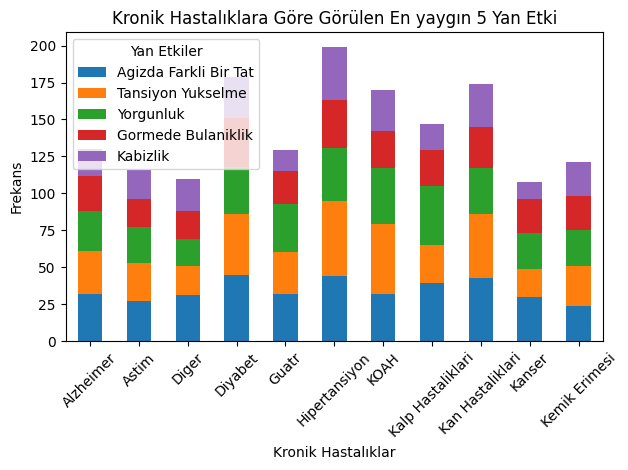

In [74]:
# Tekilleştirilmiş Kronik Rahatsızlıklarda Görülen En Yaygın 5 Yan Etki
kronik_yan_etki = df_kronik.groupby(
    ["Kronik Hastaliklarim", "Yan_Etki"]).size().unstack(fill_value=0)
filtreed_yan_etki = kronik_yan_etki.loc[:, top5_yan_etki]
filtreed_yan_etki.plot(kind="bar", stacked=True)
plt.xlabel("Kronik Hastalıklar")
plt.ylabel("Frekans")
plt.title("Kronik Hastalıklara Göre Görülen En yaygın 5 Yan Etki")
plt.xticks(rotation=45)
plt.legend(title="Yan Etkiler")
plt.tight_layout()
plt.show()

# Veri Ön Hazırlık İşlemleri


### Veri Seti Problemleri Tespiti

<Axes: >

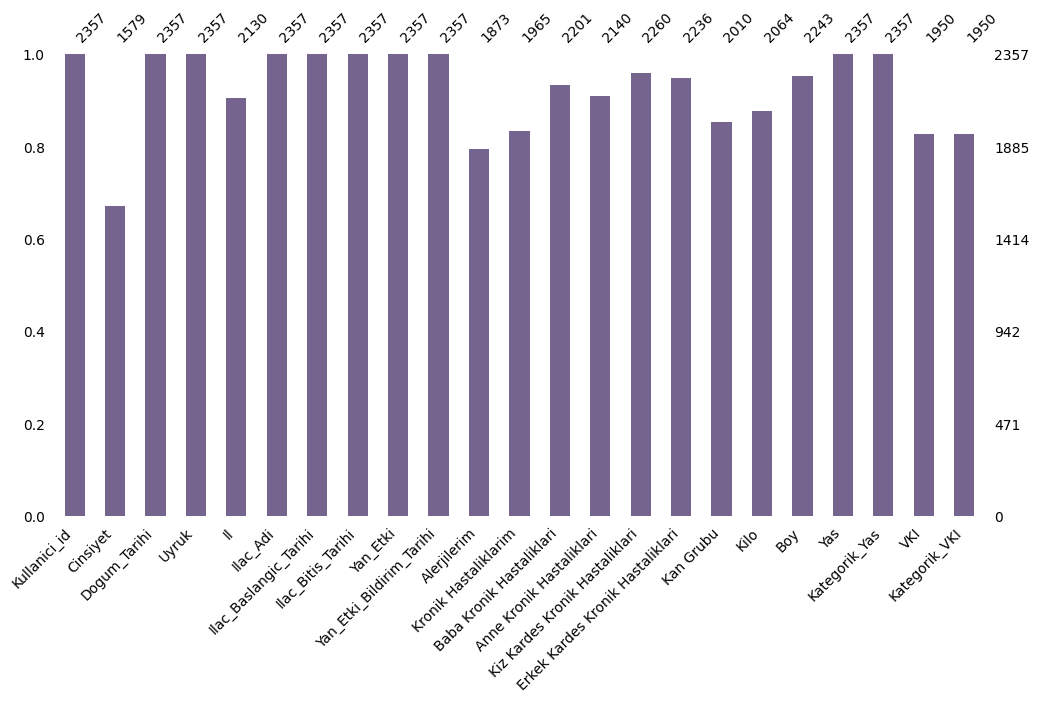

In [76]:
# 1. Eksik Veri Problemleri
msno.bar(df, color="#75658e", figsize=(12, 6), fontsize=10)

In [77]:
# 2. Tek Hücrede Birden Fazla Değer Problemi
df["Kronik Hastaliklarim"].value_counts()

Kronik Hastaliklarim
Alzheimer, Diger                       61
Kan Hastaliklari, Hipertansiyon        58
Alzheimer, Astim                       57
KOAH, Guatr                            55
Kemik Erimesi, Kan Hastaliklari        48
Kan Hastaliklari, Astim                47
Kan Hastaliklari, Diyabet              43
Kemik Erimesi, Alzheimer               43
Diyabet, Guatr                         42
Diyabet, Diger                         41
Hipertansiyon                          41
Alzheimer, Hipertansiyon               41
Kemik Erimesi                          40
Astim, Kalp Hastaliklari               39
KOAH, Kemik Erimesi                    39
Kalp Hastaliklari, Diyabet             38
Kan Hastaliklari, Diger                37
KOAH, Hipertansiyon                    36
Kanser, Diyabet                        35
KOAH, Alzheimer                        34
Diyabet, Hipertansiyon                 34
Kemik Erimesi, Hipertansiyon           33
Kalp Hastaliklari, Kanser              32
Guatr        

In [78]:
# 3. Veri Girişinden Oluşabilecek Problemler
df["Ilac_Adi"].value_counts()
kremler = df[df["Ilac_Adi"].str.contains("cream")]
kremler["Yan_Etki"].value_counts()  # Problem mevcut

Yan_Etki
Agizda Farkli Bir Tat    15
Gormede Bulaniklik       12
Tansiyon Yukselme        11
Ishal                    11
Kabizlik                  9
Karin Agrisi              9
Yorgunluk                 8
Mide Bulantisi            8
Az Uyuma                  7
Kas Agrisi                6
Istah Artisi              4
Uykululuk Hali            4
Gec Bosalma               4
Deride Morarma            4
Huzursuzluk               3
Bulanti                   3
Tansiyon Dusuklugu        3
Terleme                   3
Bas Agrisi                3
Gucsuzluk                 3
Carpinti                  2
Sinirlilik                2
Name: count, dtype: int64

**Kremlerde bu yan etkilerin görülmesi son derece şüpheli bir durum. Bu durumun veri girişinden mi kaynaklandığı yoksa insanların kremleri yediğimi bilinmediği için veriler üzerinde bir işlem yapılmayacaktır.
**

In [79]:
# Tekilleştirme Problemi Çözümü
kronik_hastaliklar = [
    "Kronik Hastaliklarim",
    "Baba Kronik Hastaliklari",
    "Anne Kronik Hastaliklari",
    "Kiz Kardes Kronik Hastaliklari",
    "Erkek Kardes Kronik Hastaliklari"]
df[kronik_hastaliklar] = df[kronik_hastaliklar].apply(
    lambda col: col.str.split(", "))

for col in kronik_hastaliklar:
    df = df.explode(col)

In [80]:
# Tekilleştirilmiş Satırların ve Diğer Kategorik Verilerin Eksik Verilerinin Doldurulması
eksik_cat = [
    "Alerjilerim",
    "Kronik Hastaliklarim",
    "Baba Kronik Hastaliklari",
    "Anne Kronik Hastaliklari",
    "Kiz Kardes Kronik Hastaliklari",
    "Erkek Kardes Kronik Hastaliklari"]
eksik_bil = ["Cinsiyet", "Kan Grubu"]

# Hastalıklar için
for col in eksik_cat:
    df[col] = df[col].fillna("Bilinen Hastalık Yok")
# Bilinmeyen değerler için
for col in eksik_bil:
    df[col] = df[col].fillna("Bilinmiyor")
# İl Değişkeni için en çok tekrar eden değerle doldurma işlemi
df["Il"] = df["Il"].fillna(df["Il"].mode()[0])

Hastalıklar için : **"Bilinen Hastalık Yok"**

İl değişkeni için : En sık tekrar eden değer

Diğer kategoriler için : **"Bilinmiyor"**



In [81]:
# Sayısal Değerler için KNN Algoritması ile tahmine dayalı doldurma işlemi
na_num_cols = ["Kilo", "Boy"]
imputer = KNNImputer(n_neighbors=5)
df[na_num_cols] = imputer.fit_transform(df[na_num_cols])

In [83]:
# # İlgili İşlemler yapıldıktan sonra Yeniden VKI hesaplama işleminin yapılması
df["VKI"] = df["Kilo"] / (df["Boy"] / 100) ** 2
df["Kategorik_VKI"] = pd.cut(
    x=df["VKI"],
    bins=[
        0, 18.5, 24.9, 29.9, 39.9, (df["VKI"].max())],
    labels=[
        "Zayıf",
        "Normal Kilolu",
        "Fazla Kilolu",
        "Obez",
        "Aşırı Obez"])


In [85]:
# Eksik Verimiz Var mı Kontrol Edelim
df.isnull().sum().any()

False

In [86]:
# Son durumda kategorik ve numerik veriler
cat_cols, num_cols, cat_but_car, date_cols = grab_col_names(df)

Observations: 37016
Variables: 23
cat_cols: 13
num_cols: 5
cat_but_car: 1
num_but_cat: 2
date_cols: 4


In [87]:
# One Hot Encoder İşlemi
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(
        dataframe,
        columns=categorical_cols,
        drop_first=drop_first)
    return dataframe


df = one_hot_encoder(df, cat_cols, drop_first=True)

df.shape

(37016, 147)

In [88]:
# Numerik değişkenler için standartlaştırma işlemi

ss = StandardScaler()

df[num_cols] = ss.fit_transform(df[num_cols])